# CNN Model

In [ ]:
import torch
from torchvision.transforms import v2
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt

from src.MNISTDataset import MNISTDataset
from src.model import ModelCNN
from src.train import Trainer
from src.evaluate import Evaluation

Using device: mps


In [2]:
model = ModelCNN()
mean = 0.1307
std = 0.3081
transformers = v2.Compose([v2.RandomRotation(10), v2.RandomAffine(0, translate=[0.1, 0.1]), v2.ToImage(), v2.Grayscale(), v2.ToDtype(dtype=torch.float32), v2.Normalize((mean,), (std,))])
train_dataset = MNISTDataset(path='data', train=True, transforms=transformers)

dataset_val, dataset_train = data.random_split(dataset=train_dataset, lengths=[0.3, 0.7])
dl_train = data.DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
dl_val = data.DataLoader(dataset=dataset_val, batch_size=len(dataset_val))
    
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.0001)

In [3]:
trainer = Trainer(model, 'CNN Model', epochs=30, loss_func=loss_func, optimizer=optimizer, train_set=dl_train, val_set=dl_val)
model = trainer.train()

Epoch [1/30] | loss_mean=0.252, Q_val=0.112


Epoch [2/30] | loss_mean=0.110, Q_val=0.089


Epoch [3/30] | loss_mean=0.089, Q_val=0.087


Epoch [4/30] | loss_mean=0.073, Q_val=0.073


Epoch [5/30] | loss_mean=0.070, Q_val=0.077


Epoch [6/30] | loss_mean=0.065, Q_val=0.065


Epoch [7/30] | loss_mean=0.057, Q_val=0.051


Epoch [8/30] | loss_mean=0.055, Q_val=0.056


Epoch [9/30] | loss_mean=0.054, Q_val=0.048


Epoch [10/30] | loss_mean=0.051, Q_val=0.081


Epoch [11/30] | loss_mean=0.047, Q_val=0.054


Epoch [12/30] | loss_mean=0.046, Q_val=0.043


Epoch [13/30] | loss_mean=0.045, Q_val=0.042


Epoch [14/30] | loss_mean=0.043, Q_val=0.048


Epoch [15/30] | loss_mean=0.043, Q_val=0.055


Epoch [16/30] | loss_mean=0.043, Q_val=0.043


Epoch [17/30] | loss_mean=0.041, Q_val=0.055


Epoch [18/30] | loss_mean=0.041, Q_val=0.040


Epoch [19/30] | loss_mean=0.039, Q_val=0.058


Epoch [20/30] | loss_mean=0.039, Q_val=0.045


Epoch [21/30] | loss_mean=0.039, Q_val=0.051


Epoch [22/30] | loss_mean=0.039, Q_val=0.038


Epoch [23/30] | loss_mean=0.037, Q_val=0.042


Epoch [24/30] | loss_mean=0.036, Q_val=0.035


Epoch [25/30] | loss_mean=0.036, Q_val=0.043


Epoch [26/30] | loss_mean=0.036, Q_val=0.047


Epoch [27/30] | loss_mean=0.036, Q_val=0.040


Epoch [28/30] | loss_mean=0.036, Q_val=0.049


Epoch [29/30] | loss_mean=0.035, Q_val=0.042


Epoch [30/30] | loss_mean=0.036, Q_val=0.034


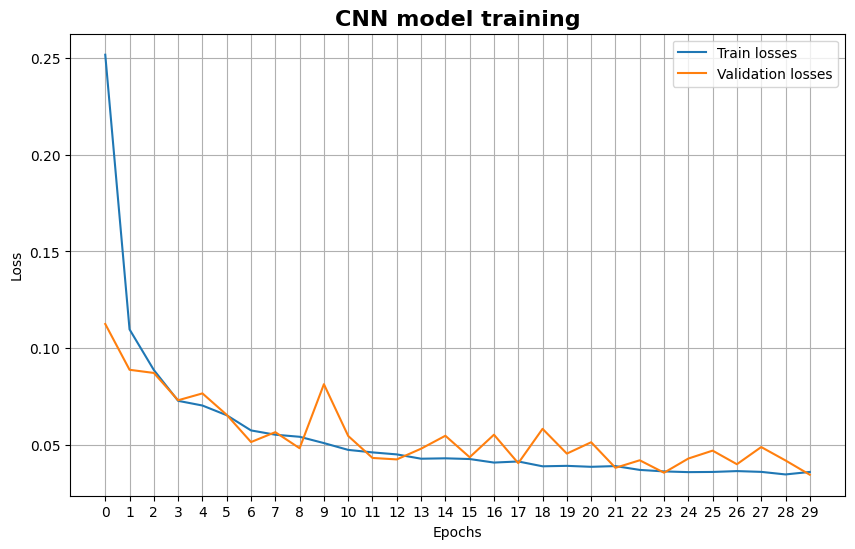

In [4]:
trainer.train_plot('CNN model training', save=True)

In [5]:
model.load_state_dict(torch.load('models/CNN Model_20.tar'))
model.eval()
test_dataset = MNISTDataset(path='data', train=False, transforms=v2.Compose([v2.ToImage(), v2.Grayscale(), v2.ToDtype(dtype=torch.float32), v2.Normalize((mean,), (std,))]))

evaluation = Evaluation(model, test_dataset)
evaluation.accuracy()
evaluation.precision_recall()
evaluation.f1();


Accuracy score: 0.99
Precision score: 0.99
Recall score: 0.99
F1 score: 0.99


In [6]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=64)
incorrect_predictions = []
model = model.cpu()
with torch.no_grad():
    for images, labels in test_loader:
        true_labels_idx = torch.argmax(labels, dim=1)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes_idx = torch.argmax(probabilities, dim=1)

        for i in range(images.size(0)):
            if predicted_classes_idx[i] != true_labels_idx[i]:
                denormalized_image = (images[i].cpu().numpy() * std) + mean

                incorrect_predictions.append({
                    'image': denormalized_image.squeeze(), 
                    'true_label': true_labels_idx[i].item(),
                    'predicted_label': predicted_classes_idx[i].item()
                })

print(f'Найдено {len(incorrect_predictions)} ошибочных предсказаний')


Найдено 73 ошибочных предсказаний


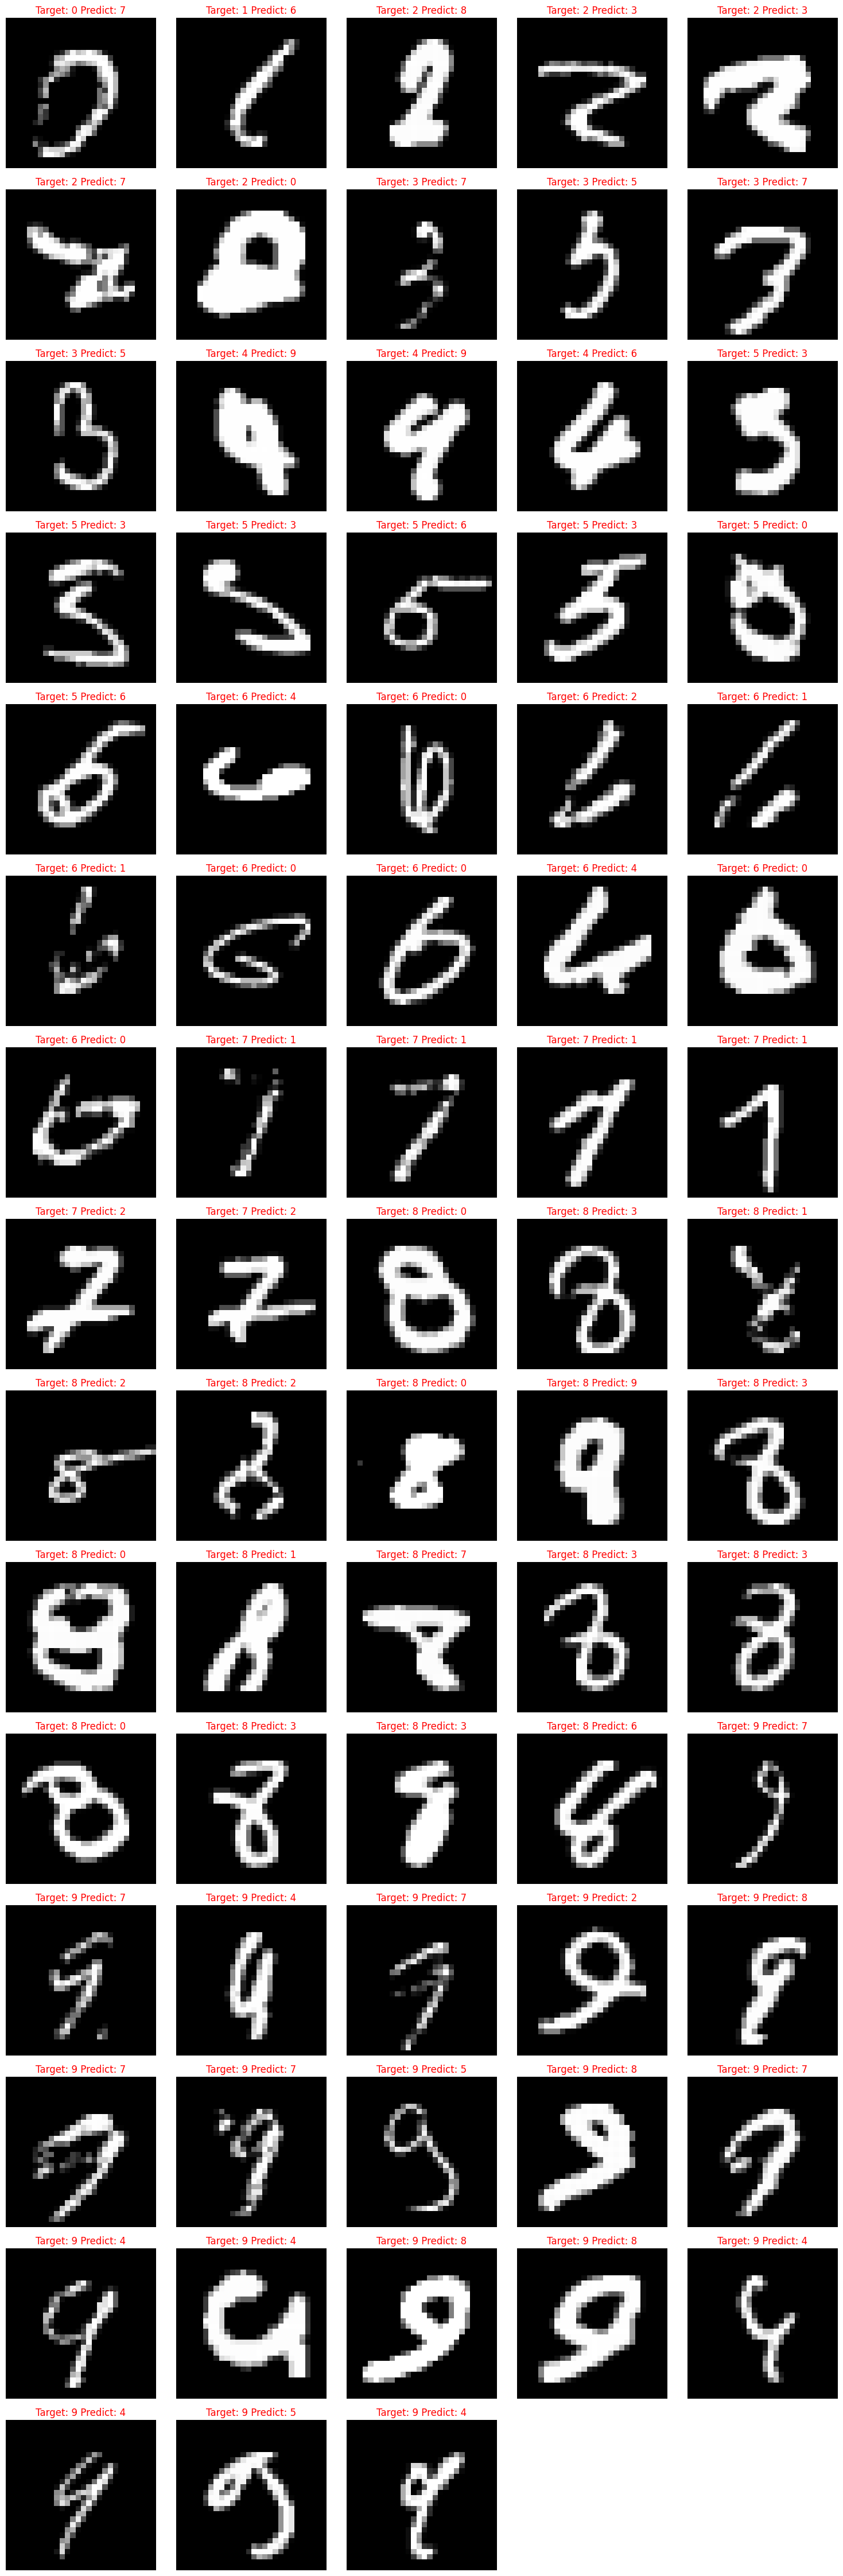

In [7]:
if incorrect_predictions:
    num_display = len(incorrect_predictions)

    fig, axes = plt.subplots(int(np.ceil(num_display / 5)), 5, figsize=(15, int(np.ceil(num_display / 5)) * 3))
    axes = axes.flatten()
    for i in range(num_display):
        item = incorrect_predictions[i]
        ax = axes[i]
        ax.imshow(item['image'], cmap='gray') 
        ax.set_title(f"Target: {item['true_label']} Predict: {item['predicted_label']}", color='red')
        ax.axis('off')

    for j in range(num_display, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()